# 1.4g: Adjacency Graph Analysis

This notebook builds an adjacency graph to identify discrete clusters within the overdensity.

## The Question

We've seen:
- Pairwise distances show complex structure with a singularity (1.4c)
- Nearest neighbor analysis reveals a dense core with accretion (1.4f)
- Traditional density metrics fail in 2560-D (curse of dimensionality)

But we can ask a **discrete question**: Which tokens are "touching"?

By defining a distance threshold and treating tokens within that distance as connected, we can:
- Identify distinct clusters (connected components)
- Count cluster populations
- Measure cluster diameters (max internal distance)
- Quantify inter-cluster separation

This bypasses the volumetric density paradox and gives us concrete, countable structure.

## Method

We'll:
1. Load the distance matrix from 1.4b
2. Define a distance threshold for "adjacency"
3. Build an adjacency graph (tokens are nodes, edges connect close pairs)
4. Find connected components (clusters)
5. Analyze cluster statistics

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Adjacency threshold (tokens within this distance are "touching")
ADJACENCY_THRESHOLD = 0.002

# Reporting
NUM_CLUSTERS_TO_SHOW = 20  # Show stats for top N clusters

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
from collections import Counter
import scipy.sparse as sp
from scipy.sparse.csgraph import connected_components

## Load Distance Matrix

In [3]:
# Load distances and token IDs from 1.4b
tensor_path = Path(f"../tensors/{MODEL_NAME}/1.4b_overdensity_distances.safetensors")
data = load_file(tensor_path)
dists = data['distances']
spike_token_ids = data['spike_token_ids']

print(f"Loaded distance matrix from {tensor_path}")
print(f"  Shape: {dists.shape}")
print(f"  Tokens: {len(spike_token_ids):,}")

Loaded distance matrix from ../tensors/Qwen3-4B-Instruct-2507/1.4b_overdensity_distances.safetensors
  Shape: torch.Size([20373, 20373])
  Tokens: 20,373


## Build Adjacency Matrix

In [4]:
print(f"\nBuilding adjacency matrix with threshold = {ADJACENCY_THRESHOLD}...\n")

# Create binary adjacency matrix: 1 if distance < threshold, 0 otherwise
adjacency = (dists < ADJACENCY_THRESHOLD).float()

# Remove self-loops (diagonal should be 0)
adjacency.fill_diagonal_(0)

# Count edges
num_edges = adjacency.sum().item() // 2  # Divide by 2 because matrix is symmetric

print(f"✓ Adjacency matrix created")
print(f"  Nodes (tokens): {len(adjacency):,}")
print(f"  Edges (adjacent pairs): {int(num_edges):,}")
print(f"  Density: {num_edges / (len(adjacency) * (len(adjacency) - 1) / 2) * 100:.4f}%")


Building adjacency matrix with threshold = 0.002...

✓ Adjacency matrix created
  Nodes (tokens): 20,373
  Edges (adjacent pairs): 2,445,366
  Density: 1.1784%


## Find Connected Components

In [5]:
print(f"\nFinding connected components...\n")

# Convert to scipy sparse matrix for efficient component finding
adjacency_sparse = sp.csr_matrix(adjacency.numpy())

# Find connected components
n_components, labels = connected_components(
    csgraph=adjacency_sparse, 
    directed=False, 
    return_labels=True
)

print(f"✓ Found {n_components:,} connected components (clusters)\n")

# Count component sizes
component_sizes = Counter(labels)
sorted_components = sorted(component_sizes.items(), key=lambda x: x[1], reverse=True)

print(f"Component size distribution:")
print(f"  Largest component: {sorted_components[0][1]:,} tokens")
print(f"  Smallest component: {sorted_components[-1][1]:,} tokens")
print(f"  Mean size: {np.mean(list(component_sizes.values())):.1f} tokens")
print(f"  Median size: {np.median(list(component_sizes.values())):.1f} tokens")


Finding connected components...

✓ Found 18,162 connected components (clusters)

Component size distribution:
  Largest component: 2,212 tokens
  Smallest component: 1 tokens
  Mean size: 1.1 tokens
  Median size: 1.0 tokens


## Cluster Statistics

In [6]:
print(f"\nTop {NUM_CLUSTERS_TO_SHOW} clusters by population:\n")
print(f"{'Cluster ID':<12} {'Population':<12} {'Diameter':<15} {'Description'}")
print("-" * 70)

for i, (cluster_id, population) in enumerate(sorted_components[:NUM_CLUSTERS_TO_SHOW]):
    # Get token indices in this cluster
    cluster_mask = labels == cluster_id
    cluster_indices = np.where(cluster_mask)[0]
    
    # Compute cluster diameter (max pairwise distance within cluster)
    if population > 1:
        cluster_dists = dists[cluster_indices][:, cluster_indices]
        diameter = cluster_dists.max().item()
    else:
        diameter = 0.0
    
    # Description
    if population == 1:
        desc = "Singleton (isolated token)"
    elif population < 10:
        desc = "Small cluster"
    elif population < 100:
        desc = "Medium cluster"
    else:
        desc = "Large cluster"
    
    print(f"{cluster_id:<12} {population:<12,} {diameter:<15.6f} {desc}")


Top 20 clusters by population:

Cluster ID   Population   Diameter        Description
----------------------------------------------------------------------
0            2,212        0.001607        Large cluster
1            1            0.000000        Singleton (isolated token)
2            1            0.000000        Singleton (isolated token)
3            1            0.000000        Singleton (isolated token)
4            1            0.000000        Singleton (isolated token)
5            1            0.000000        Singleton (isolated token)
6            1            0.000000        Singleton (isolated token)
7            1            0.000000        Singleton (isolated token)
8            1            0.000000        Singleton (isolated token)
9            1            0.000000        Singleton (isolated token)
10           1            0.000000        Singleton (isolated token)
11           1            0.000000        Singleton (isolated token)
12           1            0

## Size Distribution Histogram


Cluster size distribution:

  Singletons (size = 1): 18,161
  Small (2-9): 0
  Medium (10-99): 0
  Large (100+): 1



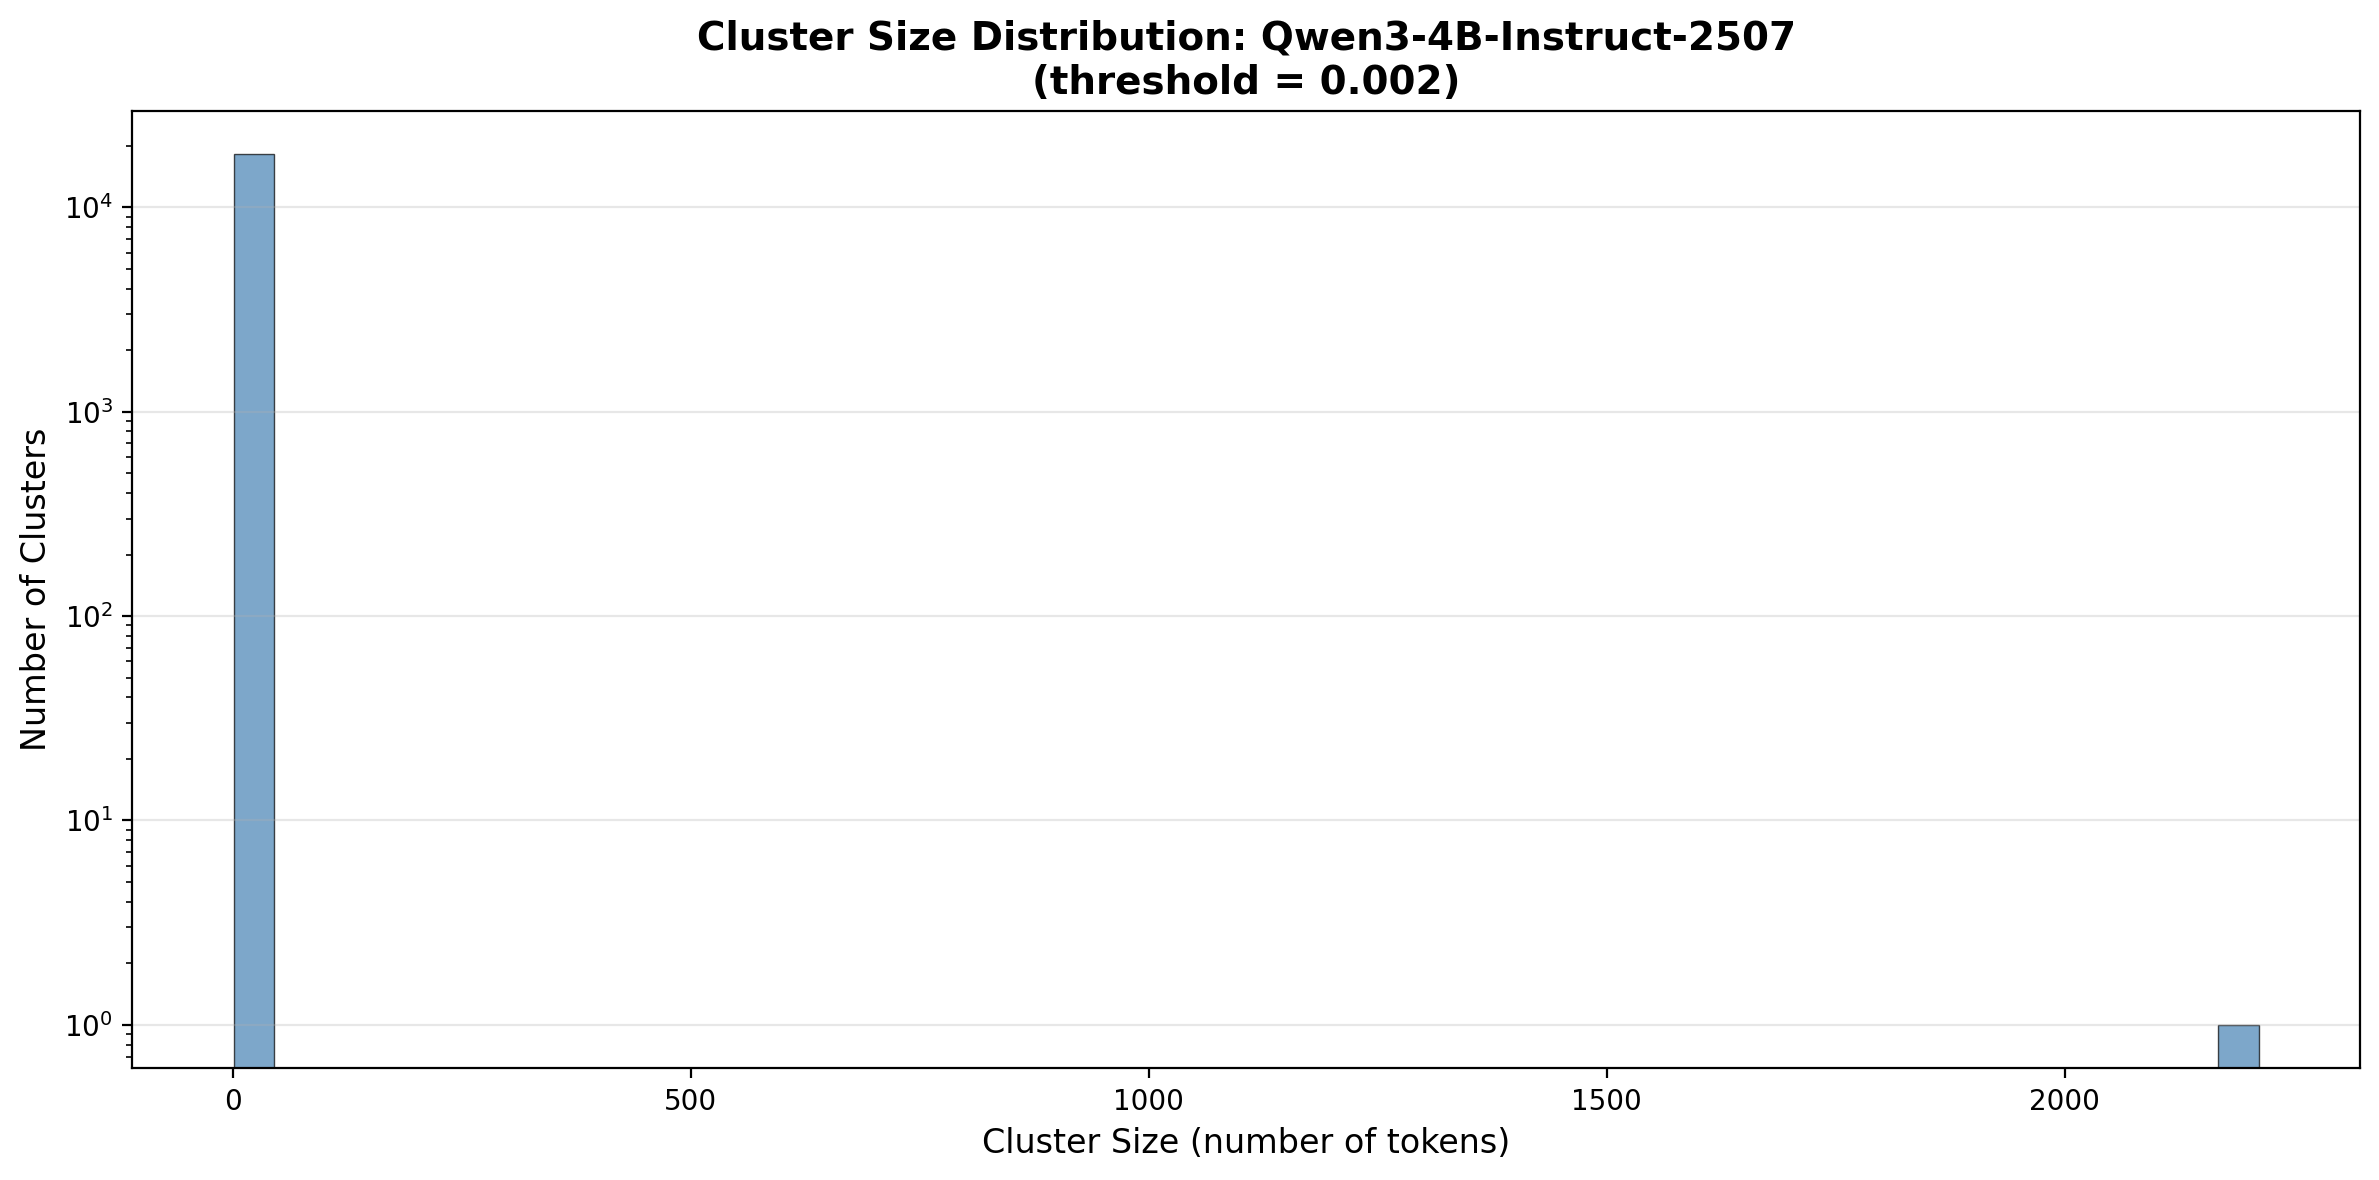

✓ Histogram complete


In [7]:
import matplotlib.pyplot as plt

print(f"\nCluster size distribution:\n")

sizes = list(component_sizes.values())

# Count by category
singletons = sum(1 for s in sizes if s == 1)
small = sum(1 for s in sizes if 2 <= s < 10)
medium = sum(1 for s in sizes if 10 <= s < 100)
large = sum(1 for s in sizes if s >= 100)

print(f"  Singletons (size = 1): {singletons:,}")
print(f"  Small (2-9): {small:,}")
print(f"  Medium (10-99): {medium:,}")
print(f"  Large (100+): {large:,}")
print()

# Plot
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

ax.hist(sizes, bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Cluster Size (number of tokens)', fontsize=12)
ax.set_ylabel('Number of Clusters', fontsize=12)
ax.set_title(f'Cluster Size Distribution: {MODEL_NAME}\n(threshold = {ADJACENCY_THRESHOLD})',
             fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Histogram complete")

## Inter-Cluster Distances

For the largest clusters, what are the distances between them?

In [11]:
print(f"\nDistances from giant cluster (cluster 0) to all singletons:\n")

# Get the giant cluster (cluster 0)
giant_cluster_id = sorted_components[0][0]
giant_mask = labels == giant_cluster_id
giant_indices = np.where(giant_mask)[0]

# Compute distances from giant cluster to all other clusters (singletons)
cluster_distances = []

for cluster_id, population in sorted_components[1:]:  # Skip cluster 0 itself
    # Get token indices for this cluster
    cluster_mask = labels == cluster_id
    cluster_indices = np.where(cluster_mask)[0]
    
    # Get inter-cluster distances
    inter_dists = dists[giant_indices][:, cluster_indices]
    
    min_dist = inter_dists.min().item()
    mean_dist = inter_dists.mean().item()
    max_dist = inter_dists.max().item()
    
    cluster_distances.append((cluster_id, population, min_dist, mean_dist, max_dist))

# Sort by minimum distance
cluster_distances.sort(key=lambda x: x[2])

print(f"\n{'='*80}")
print(f"NEAREST 20 SINGLETONS (closest to the giant cluster):")
print(f"{'='*80}\n")
print(f"{'Cluster ID':<12} {'Population':<12} {'Min Distance':<15} {'Mean Distance':<15} {'Max Distance'}")
print("-" * 80)

for cluster_id, pop, min_dist, mean_dist, max_dist in cluster_distances[:20]:
    print(f"{cluster_id:<12} {pop:<12} {min_dist:<15.6f} {mean_dist:<15.6f} {max_dist:<15.6f}")

print(f"\n{'='*80}")
print(f"FARTHEST 20 SINGLETONS (most distant from the giant cluster):")
print(f"{'='*80}\n")
print(f"{'Cluster ID':<12} {'Population':<12} {'Min Distance':<15} {'Mean Distance':<15} {'Max Distance'}")
print("-" * 80)

for cluster_id, pop, min_dist, mean_dist, max_dist in cluster_distances[-20:]:
    print(f"{cluster_id:<12} {pop:<12} {min_dist:<15.6f} {mean_dist:<15.6f} {max_dist:<15.6f}")

print(f"\n{'='*80}")
print(f"SUMMARY:")
print(f"{'='*80}")
print(f"  Void width (nearest singleton): {cluster_distances[0][2]:.6f}")
print(f"  Volume extent (farthest singleton): {cluster_distances[-1][2]:.6f}")
print(f"  Mean distance to all singletons: {np.mean([x[3] for x in cluster_distances]):.6f}")


Distances from giant cluster (cluster 0) to all singletons:


NEAREST 20 SINGLETONS (closest to the giant cluster):

Cluster ID   Population   Min Distance    Mean Distance   Max Distance
--------------------------------------------------------------------------------
6886         1            0.003565        0.003572        0.003726       
7499         1            0.003696        0.003702        0.003830       
1408         1            0.005490        0.005495        0.005591       
18151        1            0.006800        0.006882        0.007176       
18150        1            0.007548        0.007598        0.007740       
13157        1            0.007727        0.007801        0.008007       
8105         1            0.008568        0.008590        0.008700       
11839        1            0.009209        0.009262        0.009345       
12406        1            0.009534        0.009575        0.009647       
11828        1            0.014590        0.014709        0.0149

## Observations

The adjacency graph reveals discrete structure:

**If there's one giant component:**
- All tokens within the threshold are transitively connected
- Suggests a single dense cluster (possibly with internal structure)
- Diameter tells us the span of this cluster

**If there are multiple large components:**
- Multiple discrete clusters separated by gaps > threshold
- Inter-cluster distances quantify the separation
- Population distribution shows hierarchy

**Singletons and small clusters:**
- Isolated tokens or tiny groups
- These are the "normal" tokens passing through the region
- Not part of the dense core

This graph structure is concrete and countable—no curse of dimensionality, just discrete clusters with measurable properties.